In [1]:
### Inital setup

#IMPORTING MODULES

import numpy as np
import pandas as pd
import os
from astropy.timeseries import LombScargle
import lightkurve as lk
import matplotlib.pyplot as plt
import shutil
from astropy.utils.data import _get_download_cache_loc

In [2]:
### Getting data needed for Echelle diagram

def selective_search(tic_id):
    search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS')

    if not search_result:
        print(f"⚠️ No TESS light curves found for TIC {tic_id}.")
        return None
    
    try:
        selec_search = search_result[search_result.author == 'SPOC']
        exptimes = selec_search.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = selec_search[min_index]
    except:
        print("No Spoc result found")
        exptimes = search_result.table['exptime']
        min_index = exptimes.argmin()
        parsed_search = search_result[min_index]
        
    return parsed_search

#downloading data and removing bad data points function

def dwnlwd(parsed_search):
    data = parsed_search.download(quality_bitmask='default').remove_nans()
    return data

#rough plot

def quick_look(data):
    data.plot()
    plt.show()

#extracting data

def extracter(data):
    #.remove_outliers()
    
    time, flux = data.time.value, data.flux.value
    flux /= np.median(flux)
    time -= time[0]

    return time, flux

#calculating fourier transform

def calc_lomb_scargle(t,y):
    oversample = 10 # can be adjusted
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    fmin = df
    fmax = 1000 # set max freq in c/d

    freq = np.arange(fmin, fmax, df / oversample)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct * 1e6
    return freq, amp # freq in cycles per day and amp in ppm

#compilation function

def data_retriever(tic_id):

    parsed_search_result = selective_search(tic_id)

    if parsed_search_result == None:
        return
    
    data = dwnlwd(parsed_search_result)

    time, flux = extracter(data)

    freq, amp = calc_lomb_scargle(time, flux)

    return freq, amp

In [3]:
### Determining delta nu min and max

#Absolute magnitude
raw_table = pd.read_csv("tess_sector_91_92.csv",skiprows=[0, 1],names=["update_date","main_id","TICID","gaiadr3_id","CCD","Tmag","RA","Dec","sector","count","sp_type","sp_qual","plx_value","V","B","G","otype","nbref","rvz_radvel","rvz_redshift","gaiadr3_plx","gaiadr3phot_g_mean_mag","gaiadr3_bp_rp","abs_mag_rough"])

def finder(search_column, return_column, tic_id):
    try:
        # Find the index where the search_column equals the search_number
        index_of_match = raw_table[raw_table[search_column] == tic_id].index[0]
        # Use .loc to get the value at that specific index and column
        return raw_table.loc[index_of_match, return_column]
    except IndexError:
        # This handles the case where no match is found
        return None

def abs_mag_r(tic_id):
    try:
        apar = float(finder("TICID","gaiadr3phot_g_mean_mag",tic_id))
        dist = (1/float(finder("TICID","gaiadr3_plx",tic_id)))*1e3
        return apar - 5*np.log10(dist/10)
    except:
        return None

#find delta_nu using PL Relation equation

def delta_nu(abs_mag):
    period = 10**((abs_mag + 1.4)/(-3.01))

    frequency_fund = 1/period

    print(frequency_fund)

    Delta_nu = frequency_fund/3

    print(Delta_nu)

    return Delta_nu


In [4]:
### Stars which we wish to analyse

ioi = [71859994, 288404080,288143236,368759]
names = ["Eta Lib", "18 Aqr","31 Cap","V4190 Sgr"]

In [12]:
### Creating interactive Echelle Diagram

from echelle import interact_echelle

%matplotlib widget

15.128835453043521
5.042945151014507
%1.18f


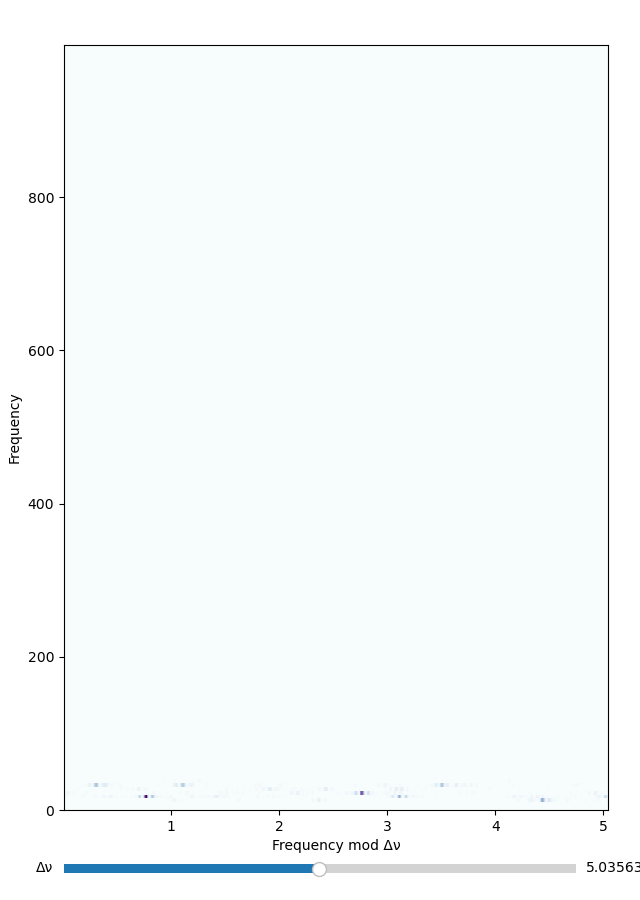

In [13]:
#Eta lib interactive

frequency = data_retriever(ioi[0])[0]
power = (data_retriever(ioi[0])[1])**2

abs_mag = abs_mag_r(ioi[0])
Delta_nu = delta_nu(abs_mag)

bound = 2
#figsize = [4,6]

interact_echelle(frequency, power, Delta_nu - bound, Delta_nu + bound, backend='matplotlib')
fig = plt.gcf()
fig.set_size_inches(4, 6)
for ax in fig.axes:
    ax.set_ylim(0, 50)

13.848056866273108
4.616018955424369
%1.18f


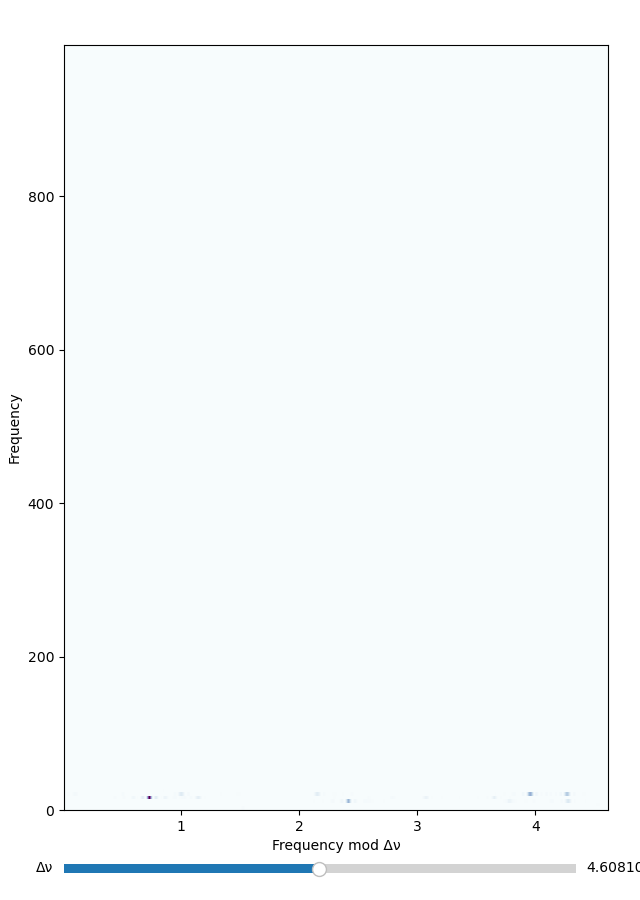

In [17]:
#18 aqr interactive

frequency = data_retriever(ioi[1])[0]
power = (data_retriever(ioi[1])[1])**2

abs_mag = abs_mag_r(ioi[1])
Delta_nu = delta_nu(abs_mag)

bound = 2
#figsize = [4,6]

interact_echelle(frequency, power, Delta_nu - bound, Delta_nu + bound, backend='matplotlib')
fig = plt.gcf()
fig.set_size_inches(4, 6)
for ax in fig.axes:
    ax.set_ylim(0, 25)

13.869069894545653
4.623023298181884
%1.18f


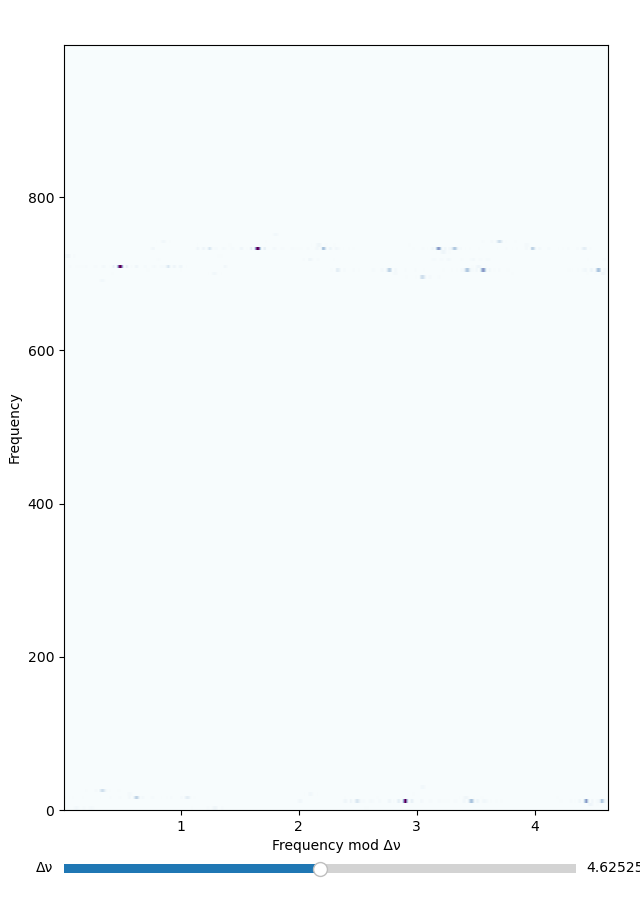

In [15]:
#31 cap interactive

frequency = data_retriever(ioi[2])[0]
power = (data_retriever(ioi[2])[1])**2

abs_mag = abs_mag_r(ioi[2])
Delta_nu = delta_nu(abs_mag)

bound = 2
#figsize = [4,6]

interact_echelle(frequency, power, Delta_nu - bound, Delta_nu + bound, backend='matplotlib')
fig = plt.gcf()
fig.set_size_inches(4, 6)
for ax in fig.axes:
    ax.set_ylim(0, 50)

10.15728959364557
3.385763197881857
%1.18f


/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_5853/295783967.py:61: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_5853/295783967.py:61: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6


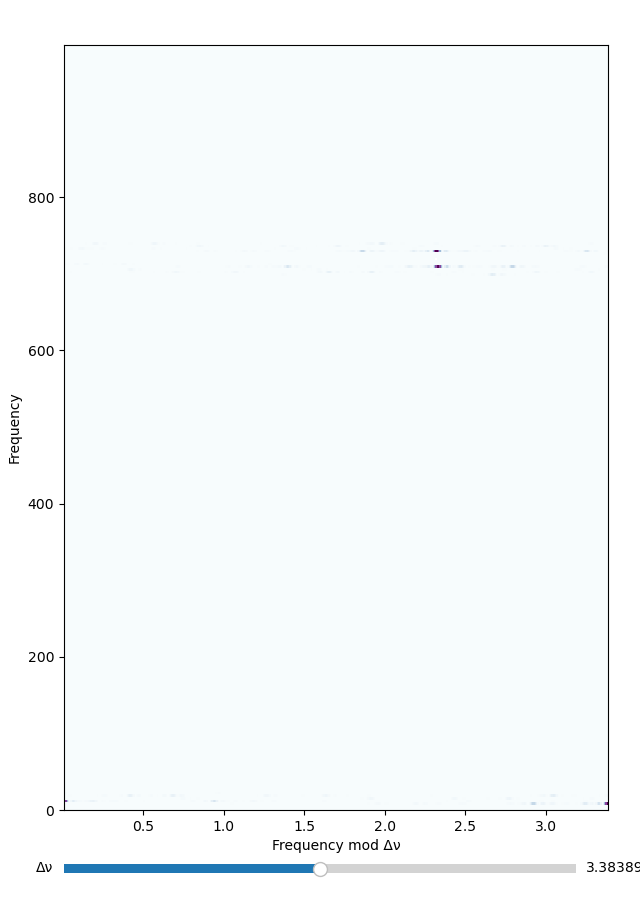

In [16]:
#V4190 Sag interactive

frequency = data_retriever(ioi[3])[0]
power = (data_retriever(ioi[3])[1])**2

abs_mag = abs_mag_r(ioi[3])
Delta_nu = delta_nu(abs_mag)

bound = 2
#figsize = [4,6]

interact_echelle(frequency, power, Delta_nu - bound, Delta_nu + bound, backend='matplotlib')
fig = plt.gcf()
fig.set_size_inches(4, 6)
for ax in fig.axes:
    ax.set_ylim(0, 50)

In [6]:
### Creating non-interactive Echelle Diagram

from echelle import plot_echelle

%matplotlib inline

15.128835453043521
5.042945151014507


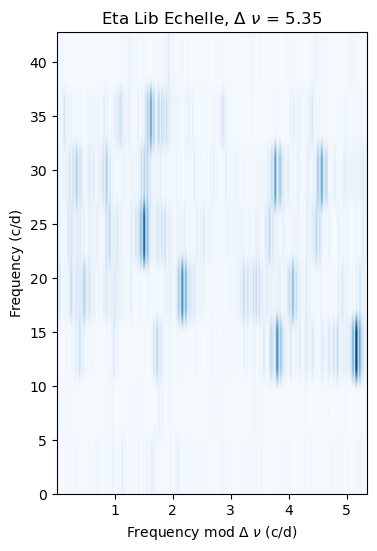

In [54]:
#Eta lib

frequency = data_retriever(ioi[0])[0]
amp = (data_retriever(ioi[0])[1])
power = amp**2

abs_mag = abs_mag_r(ioi[0])
dn = delta_nu(abs_mag)

fig, ax = plt.subplots(figsize = (4,6))
plt.title(rf"{names[0]} Echelle, $\Delta$ $\nu$ = 5.35")
plot_echelle(frequency, amp, 5.35, fmin = 0, fmax = 45, ax = ax)
plt.ylabel("Frequency (c/d)")
plt.xlabel(fr"Frequency mod $\Delta$ $\nu$ (c/d)")
plt.savefig("Etalib_echelle.png", dpi = 300)

13.848056866273108
4.616018955424369


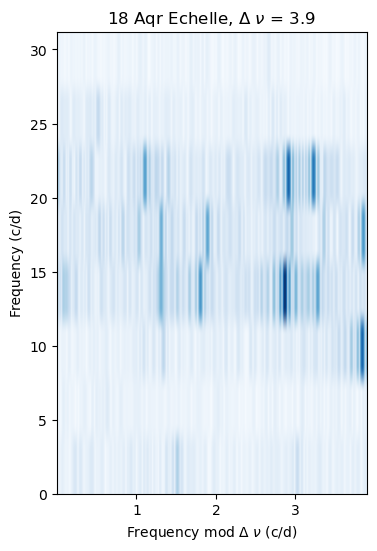

In [33]:
### Second star (using an estimated fundamental frequency from observed spectrum)

frequency = data_retriever(ioi[1])[0]
amp = data_retriever(ioi[1])[1]
power = amp**2

abs_mag = abs_mag_r(ioi[1])
dn = delta_nu(abs_mag)

fig, ax = plt.subplots(figsize = (4,6))
plot_echelle(frequency, np.sqrt(amp), 3.9, fmin = 0, fmax = 35, ax = ax)
plt.title(fr"{names[1]} Echelle, $\Delta$ $\nu$ = 3.9")
plt.ylabel("Frequency (c/d)")
plt.xlabel(fr"Frequency mod $\Delta$ $\nu$ (c/d)")
plt.savefig("18aqr_echelle.png", dpi = 300)

13.869069894545653
4.623023298181884


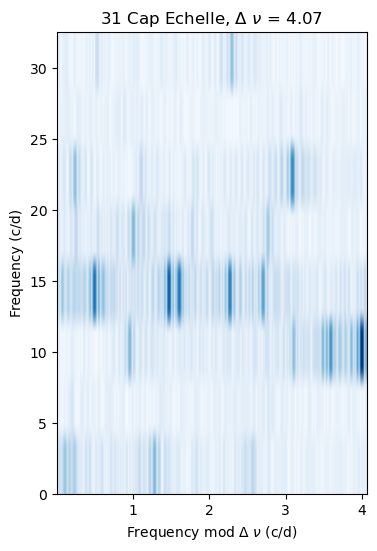

In [107]:
### Second star (using an estimated fundamental frequency from observed spectrum)

frequency = data_retriever(ioi[2])[0]
amp = data_retriever(ioi[2])[1]
power = amp**2

abs_mag = abs_mag_r(ioi[2])
dn = delta_nu(abs_mag)

fig, ax = plt.subplots(figsize = (4,6))
plot_echelle(frequency, np.sqrt(amp), 4.07, fmin = 0, fmax = 35, ax = ax)
plt.title(fr"{names[2]} Echelle, $\Delta$ $\nu$ = 4.07")
plt.ylabel("Frequency (c/d)")
plt.xlabel(fr"Frequency mod $\Delta$ $\nu$ (c/d)")
plt.savefig(f"{names[2]}_echelle.png", dpi = 300)

/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_26100/295783967.py:61: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6
/var/folders/pr/hmmmnv3x3jlf2f8nvv2vlkq40000gn/T/ipykernel_26100/295783967.py:61: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct * 1e6


10.15728959364557
3.385763197881857


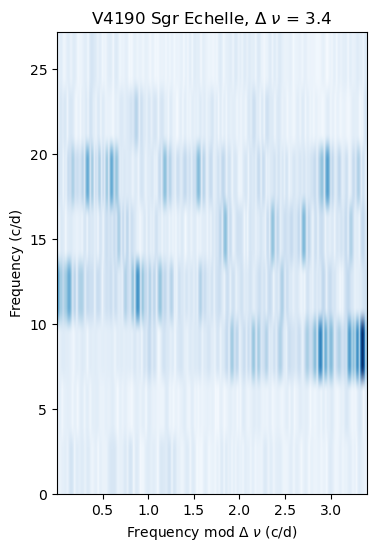

In [26]:
### v4190 (using an estimated fundamental frequency from observed spectrum)

frequency = data_retriever(ioi[3])[0]
amp = data_retriever(ioi[3])[1]
power = amp**2

abs_mag = abs_mag_r(ioi[3])
dn = delta_nu(abs_mag)

fig, ax = plt.subplots(figsize = (4,6))
plot_echelle(frequency, np.sqrt(amp), 3.4, fmin = 0, fmax = 30, ax = ax)
plt.title(fr"{names[3]} Echelle, $\Delta$ $\nu$ = 3.4")
plt.ylabel("Frequency (c/d)")
plt.xlabel(fr"Frequency mod $\Delta$ $\nu$ (c/d)")
plt.savefig("V4190Sgr_echelle.png", dpi = 300)